In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from sklearn.datasets import make_moons

In [2]:
class DiscreteFlow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 128, v: int = 128):
        super().__init__()
        self.v = v
        self.embed = nn.Embedding(v, h)
        self.net = nn.Sequential(
            nn.Linear(dim * h + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim * v))
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t[:, None], self.embed(x_t).flatten(1, 2)), -1)).reshape(list(x_t.shape) + [self.v])

# Training

In [3]:
batch_size = 256
vocab_size = 128

model = DiscreteFlow(v=vocab_size)
optim = torch.optim.Adam(model.parameters(), lr=0.001) 

for _ in range(10000):
    x_1 = Tensor(make_moons(batch_size, noise=0.05)[0])
    x_1 = torch.round(torch.clip(x_1 * 35 + 50, min=0.0, max=vocab_size - 1)).long()
    
    x_0 = torch.randint(low=0, high=vocab_size, size=(batch_size, 2))

    t = torch.rand(batch_size)
    x_t = torch.where(torch.rand(batch_size, 2) <  t[:, None], x_1, x_0)

    logits = model(x_t, t)
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()

# Sampling

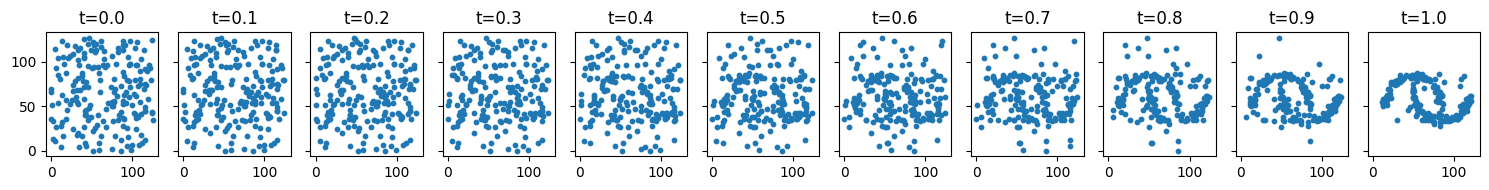

In [4]:
x_t = torch.randint(low=0, high=vocab_size, size=(200, 2))
t = 0.0
results = [(x_t, t)]
while t < 1.0 - 1e-3:
    p1 = torch.softmax(model(x_t, torch.ones(200) * t), dim=-1)
    h = min(0.1, 1.0 - t)
    one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
    u = (p1 - one_hot_x_t) / (1.0 - t)
    x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
    t += h
    results.append((x_t, t))

fig, axes = plt.subplots(1, len(results), figsize=(15, 2), sharex=True, sharey=True)

for (x_t, t), ax in zip(results, axes):
    ax.scatter(x_t.detach()[:, 0], x_t.detach()[:, 1], s=10)
    ax.set_title(f't={t:.1f}')

plt.tight_layout()
plt.show()